# **Leveraging Deep Learning Methods for Function Inverse Problems in Communication Systems**
---
Panagiotis Skrimponis and Mustafa F. Ozkoc


---




## **Our training Recipe:**

Our training methodology is inspired from transfer learning. The idea is we would like to create a model, irrespective of snr learns the intrinsic porperties of the system. Finally using this base model, we would like to train multiple models for each target SNR value. This way, we achieve the best possible performance for each SNR target. The details of the training procedure is explained on our **Project Report**.

Our training methodology can be summarized as below:


1.   **General Training**:
  1.   We train our model with all SNR inputs seperately. The dataset fed to the network in decreasing order of SNRs i.e., we train our network 10 epochs with highest SNR value, then 10 epochs followed by second highest SNR value, until we go over all specific SNR values.
  2.   We repeat Step 1.1, for 5 times. So our network is trained 50 epochs over the entire dataset.
2.   **Optimized training**:
  1.   Now that we trained our model in general dataset, we further optimize different models for each SNR value, that is for every target SNR input value, we pick the best performing model from **1.General Training**.
  2.   We train this optimal model, using only the SNR values in the vicinity of this target SNR value. i.e., for SNR value of 18, we train using SNR values \{16,17,18,19,20\}.
  3.  Finally, among those further trained models, we find the best model for each target SNR value.


## **Our dataset**

We use 200,000 samples for our training and testing. We seperate 160,000 samples for our training, the rest 40,000 samples are reserved only for testing purposes. 









## **What is in this notebook ?**
We provide this notebook as a demo and a way to reproduce our results, once the already **trained models are given**. This script is not to train the models. The training procedure takes about 20 hours on a GPU with cuda score of 7.5.

# **Reproducing Our Results**

In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

nit = 5  # num of iterations
nrx = 16  # num of receiver antennas
nsnr = 22  # num of snr points
nx = 10000  # num of tx samples


## Downloading the testing dataset

In [2]:
!mkdir -p DATASET
!gdown --id 1epi51J7CD8NtwOUQt5zmhUhR1xj3km8T  -O ./DATASET/dataset_17.csv
!gdown --id 1pE99dA24UVtLlsU2AqnXb9vOFXa8J2bP  -O ./DATASET/dataset_18.csv
!gdown --id 1l77fsHGSHaLt2cke5510rkSBwqDZYTTu  -O ./DATASET/dataset_19.csv
!gdown --id 1ABZkKXj9_NPVmF6huB5Vc44qQ7OKVCRG  -O ./DATASET/dataset_20.csv
file_path = os.path.join(os.getcwd(),'DATASET')

Downloading...
From: https://drive.google.com/uc?id=1epi51J7CD8NtwOUQt5zmhUhR1xj3km8T
To: /content/DATASET/dataset_17.csv
303MB [00:01, 185MB/s]
Downloading...
From: https://drive.google.com/uc?id=1pE99dA24UVtLlsU2AqnXb9vOFXa8J2bP
To: /content/DATASET/dataset_18.csv
303MB [00:01, 165MB/s]
Downloading...
From: https://drive.google.com/uc?id=1l77fsHGSHaLt2cke5510rkSBwqDZYTTu
To: /content/DATASET/dataset_19.csv
303MB [00:01, 183MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ABZkKXj9_NPVmF6huB5Vc44qQ7OKVCRG
To: /content/DATASET/dataset_20.csv
303MB [00:07, 40.3MB/s]


## Downloading the pre-trained models

In [3]:
!mkdir -p MODELS
!gdown --id 1J0IiFKHFiW60TbDgq73Iy3GuhGwB1QIz -O MODELS.zip
!unzip -d MODELS -oq MODELS.zip
models_folder = os.path.join(os.getcwd(),'MODELS')

Downloading...
From: https://drive.google.com/uc?id=1J0IiFKHFiW60TbDgq73Iy3GuhGwB1QIz
To: /content/MODELS.zip
116MB [00:03, 32.9MB/s]


## Parsing the testing dataset

In [4]:
def parse_file(it,file_path):
    data_path = os.path.join(file_path,'dataset_{}.csv'.format(str(it+1)))
    df = pd.read_csv(data_path)
    x = np.char.replace(np.array(df['x'], dtype=str), 'i', 'j').astype(np.complex)
    w = np.array([np.char.replace(np.array(df['w_' + str(i + 1)], dtype=str), 'i', 'j').astype(np.complex)
                  for i in range(nrx)], dtype=complex)
    y_ant = np.array([
        np.char.replace(np.array(df['yant_' + str(isnr * nrx + irx + 1)], dtype=str), 'i', 'j').astype(np.complex)
        for isnr in range(nsnr) for irx in range(nrx)
    ], dtype=complex).T.reshape(nx, nsnr, nrx)
    y_rffe = np.array([
        np.char.replace(np.array(df['yrffe_' + str(isnr * nrx + irx + 1)], dtype=str), 'i', 'j').astype(np.complex)
        for isnr in range(nsnr) for irx in range(nrx)
    ], dtype=complex).T.reshape(nx, nsnr, nrx)
    pwr_out = np.array([
        np.char.replace(np.array(df['pwrOut_' + str(isnr * nrx + irx + 1)], dtype=str), 'i', 'j').astype(np.float)
        for isnr in range(nsnr) for irx in range(nrx)
    ], dtype=float).T.reshape(nx, nsnr, nrx)
    return [x, w, y_ant, y_rffe, pwr_out]


def parse_multiple_files(it_list,file_path):
    uu=[parse_file(_,file_path) for _ in it_list]
    x       = np.concatenate([i[0] for i in uu],axis=0)
    w       = np.concatenate([i[1] for i in uu],axis=1)
    y_ant   = np.concatenate([i[2] for i in uu],axis=0)
    y_rffe  = np.concatenate([i[3] for i in uu], axis=0)
    pwr_out  = np.concatenate([i[4] for i in uu], axis=0)
    print('Testing on {} samples'.format(y_rffe.shape[0]))
    return [x, w, y_ant, y_rffe, pwr_out]

In [5]:
#Load test data
it_list_test = [16,17,18,19]
[x_test, w_test, y_ant_test, y_rffe_test, pwr_out_test] = parse_multiple_files(it_list_test,file_path)

Testing on 40000 samples


## Defining the evaluation metric
In communication systems signal to noise ratio (SNR) is a widely used metric, which directly related to the capacity of the wireless channel.
Capacity is given as:
$$C = log_2(1+SNR) \text{ bits/per channel use}$$

Thus, we use output SNR values as our success metric. 

In [6]:
def snr(Phi, x, w):
    xh = sum(Phi.T * np.conj(w), 0) / np.sum(np.abs(w) ** 2, 0)
    a = np.mean(np.conj(xh) * x) / np.mean(np.abs(x) ** 2)
    d_var = np.mean(np.abs(xh - a * x) ** 2)
    snr_out = 10 * np.log10(np.abs(a) ** 2 / d_var)
    return snr_out

## Evaluating our model on testing data

In [7]:

def test(y_rffe, pwr_out, x, w, models_folder):
    pin = np.array((
        -91.5771, -81.5771, -71.5771, -61.5771, -51.5771,
        -41.5771, -31.5771, -29.5771, -27.5771, -25.5771,
        -23.5771, -21.5771, -19.5771, -17.5771, -15.5771,
        -13.5771, -11.5771, -9.5771, -7.5771, -5.5771,
        -3.5771, -1.5771))

    pred_snr = np.zeros(nsnr)
    base_snr = np.zeros(nsnr)
    for isnr in range(nsnr):
        X = np.hstack((y_rffe[:, isnr, :].real, y_rffe[:, isnr, :].imag))
        X_min = np.min(X)
        X_max = np.max(X)
        X -= X_min
        X /= (X_max - X_min)
        X = np.hstack((X, 10 ** (0.1 * (pwr_out[:, isnr, :] - 30))))
        model_path = os.path.join(models_folder,'snr_{}'.format(isnr))
        snr_model = tf.keras.models.load_model(model_path)

        pred = snr_model(X).numpy()
        pred *= (X_max - X_min)
        pred += X_min
        pred = pred[:, :16] + 1j * pred[:, 16:]
        
        pred_snr[isnr] = snr(pred, x, w)
        base_snr[isnr] = snr(y_rffe[:, isnr, :], x, w)

    plt.figure()
    plt.title('Comparison of Baseline Method with our DNN approach')
    plt.plot(pin, base_snr, 'bs')
    plt.plot(pin, pred_snr, 'rd')
    plt.grid()
    plt.xlabel('Receive power per antenna [dBm]')
    plt.ylabel('Output SNR $\;(\gamma_\mathrm{out})\;$ [dB]')
    plt.legend(['Reference', 'DNN'])
    plt.show()
    return pred_snr,base_snr

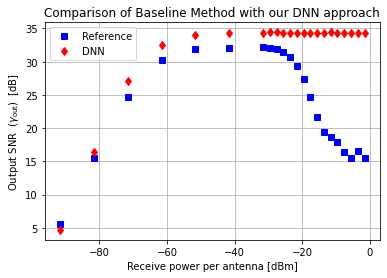

In [8]:
pred_snr,base_snr= test(y_rffe_test, pwr_out_test, x_test, w_test, models_folder)